# Restricted Boltzmann Machine Defintion

In [1]:
# TODO g = 1 + ap of g = ap

In [2]:
# Import PyTorch library
import torch
import torch.nn as nn

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [3]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Create the Restricted Boltzmann Machine architecture
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """
        self.i = 0

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.zeros(n_hid, n_vis, device=device)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.zeros(1, n_vis, device=device)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.zeros(1, n_hid, device=device)  # fake dimension for the batch = 1
    
    def lr(self):
        return 0.02

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h
        wx = torch.mm(x, self.W.t())
        # print(wx.shape)

        # Expand the mini-batch
        activation = wx + self.h_bias.expand_as(wx)
        # print(activation.shape)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # print("h sparse", p_h_given_v.is_sparse, torch.bernoulli(p_h_given_v).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """

        # Probability v is activated given that the value h is sigmoid(Wx + a)
        wy = torch.mm(y, self.W)

        # Expand the mini-batch
        activation = wy + self.v_bias.expand_as(wy)

        # Calculate the probability p_v_given_h
        p_v_given_h = torch.sigmoid(activation)

        # print("v sparse", p_v_given_h.is_sparse, torch.bernoulli(p_v_given_h).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_vis is activated or not activated
        # todo check dit
        global alpha
        # bernoulliversie = torch.ones(p_v_given_h.shape)
        # if torch.cuda.is_available():
        #     bernoulliversie = bernoulliversie.cuda()
        # for _ in range(alpha):
        #     bernoulliversie = torch.add(bernoulliversie, torch.bernoulli(p_v_given_h))
        bernoulliversie = torch.round(p_v_given_h * (alpha + 1))

        return p_v_given_h, bernoulliversie
        # return p_v_given_h,torch.bernoulli(p_v_given_h)

    def train_model(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        w_extra = (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        v_extra = torch.sum((v0 - vk), 0)
        h_extra = torch.sum((ph0 - phk), 0)

        # if self.i % 45 == 0:
            # print(torch.max(w_extra), torch.max(v_extra), torch.max(h_extra), flush=True)

        # Approximate the gradients with the CD algorithm
        # TODO learning rate toevoegen
        self.W += self.lr() * w_extra

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias += self.lr() * v_extra
        self.h_bias += self.lr() * h_extra
        self.i += 1

In [4]:
cuda = torch.device('cuda')

# General Imports

In [5]:
import numpy as np
import pickle as pickle
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

# Reading

In [6]:
with open("stijn-data/item_dct.p", "rb") as f:
    item_dict = pickle.load(f)


In [7]:
def parse_csv(filename):
    df_string = pd.read_csv("stijn-data/train_split_0.csv", index_col=0)
    df = df_string.loc[:,:]
    df["item_id"] = df["item_id"].apply(eval)
    df["playtime_forever"] = df["playtime_forever"].apply(eval)
    df["playtime_2weeks"] = df["playtime_2weeks"].apply(eval)
    return df

In [8]:
train0 = parse_csv("stijn-data/train_split_0.csv")
test0 = parse_csv("stijn-data/test_split_0.csv")

In [24]:
train0

,user_id,item_id,playtime_forever,playtime_2weeks
0,0,"[38, 200, 143, 57, 266, 173, 177, 31, 254, 78,...","[195, 319, 3, 110, 395, 296, 1, 115, 5, 1636, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[644, 478, 388, 221, 537, 514, 933, 102, 965, ...","[59, 124, 0, 2137, 180, 450, 258, 0, 225, 101,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[1036, 264, 1051, 297, 1024, 1047, 292, 1026, ...","[5957, 8344, 269, 0, 1393, 0, 0, 4, 933, 227, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,3,"[79, 1102, 1145, 1086, 465, 426, 139, 563, 81,...","[0, 0, 0, 277, 0, 0, 929, 34, 29, 0, 236, 255,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[229, 199, 1226, 1292, 1215, 14, 1320, 76, 98,...","[615, 74, 0, 0, 18, 280, 93, 18, 0, 14, 0, 973...","[0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...
65696,65696,"[2686, 1483, 2060, 2636, 854, 3204, 2491, 2383...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
65697,65697,"[191, 853]","[0, 623]","[0, 0]"
65698,65698,"[1991, 1983, 1984, 1997, 1992, 1998, 1996, 198...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
65699,65699,"[2605, 2496, 2065, 1481, 4246, 3132, 5860, 437...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
train0["item_id"].map(len).describe()

count    65701.000000
mean        50.869926
std         64.529794
min          2.000000
25%         12.000000
50%         31.000000
75%         64.000000
max        716.000000
Name: item_id, dtype: float64

In [10]:
train0.iloc[100,:]

user_id                                                           100
item_id             [221, 1698, 532, 318, 178, 101, 171, 576, 229,...
playtime_forever    [1254, 67, 1075, 597, 5195, 395, 212, 363, 574...
playtime_2weeks                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: 100, dtype: object

# Sparse Matrix

Create Sparse Matrix

In [11]:
#Create scipy csr matrix
alpha = 50 # value from paper
def get_sparse_matrix(df):
    shape = (df['user_id'].max() + 1, max(item_dict.values()) + 1)
    global alpha    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id']
        user = row['user_id']
    
        # recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        playtime = row["playtime_forever"]
        playtime_max = max(playtime)
        playtime_max = max(playtime_max, 1)
        g = []
        for i, item_id in enumerate(items):
            g.append(1 + alpha * playtime[i] // playtime_max)
        values.extend(g)
    # create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


In [12]:
test_matrix = get_sparse_matrix(test0)

train_matrix = get_sparse_matrix(train0)
train_matrix

<65701x10269 sparse matrix of type '<class 'numpy.intc'>'
	with 3342205 stored elements in Compressed Sparse Row format>

In [13]:
print(train_matrix[100, :])

  (0, 58)	1
  (0, 101)	4
  (0, 157)	51
  (0, 171)	2
  (0, 178)	44
  (0, 221)	11
  (0, 229)	5
  (0, 318)	5
  (0, 532)	9
  (0, 576)	4
  (0, 1698)	1


In [14]:
torch.manual_seed(0)

Train model

In [15]:
def score_model(rbm, batch_size, train_matrix, test_matrix):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    global alpha
    for id_user in range(0, train_matrix.shape[0] - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        # v = convert_sparse_matrix_to_sparse_tensor(training_sample)
        # vt = convert_sparse_matrix_to_sparse_tensor(training_sample2)
        v = v.todense()
        vt = vt.todense()

        # v = v.to_dense()
        # vt = vt.to_dense()
        # v = v - 1
        # vt = vt - 1
        v = torch.Tensor(v)
        vt = torch.Tensor(vt)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()
        if len(vt[vt > 0]) > 0:
            _, h = rbm.sample_h(v)
            v, _ = rbm.sample_v(h)
            v = v * (alpha + 1)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > 0] - v[vt > 0])**2)) * len(vt > 0)
            s += len(vt > 0) 

    return test_recon_error / s


# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 

def create_rbm(train_matrix, test_matrix, n_hidden, batch_size, epochs, rbm=None) -> RBM:
    """[summary]

    Args:
        train_matrix ([type]): [description]
        test_matrix ([type]): [description]
        n_hidden ([type]): [description]
        batch_size ([type]): [description]
        epochs ([type]): [description]
        rbm ([type], optional): [description]. Defaults to None.

    Returns:
        RBM: [description]
    """
    n_vis = train_matrix.shape[1]
    train_errors = []
    test_errors = []
    if rbm is None:
        rbm = RBM(n_vis, n_hidden)

    print("start training")
    for epoch in tqdm(range(epochs)):
        rbm.train()
        train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
        s = 0
        
        for user_id in range(0, train_matrix.shape[0] - batch_size, batch_size):
            training_sample = train_matrix[user_id : user_id + batch_size]
            training_sample2 = train_matrix[user_id : user_id + batch_size]
            # print(training_sample)
            v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
            # print(v0.coalesce().indices())
            vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

            v0 = v0.to_dense()
            vk = vk.to_dense()
            # v0 = v0.sub(1)
            # vk = vk.sub(1)
            
            ph0, _ = rbm.sample_h(v0)

            # Third for loop - perform contrastive divergence
            # TODO misschien is iets lager proberen?
            for k in range(1):
                _, hk = rbm.sample_h(vk)
                _, vk = rbm.sample_v(hk)

                # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
                # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
                vk[v0 < 1] = v0[v0 < 1]

            phk, _ = rbm.sample_h(vk)
            rbm.train_model(v0, vk, ph0, phk)

            global alpha
            vk, _ = rbm.sample_v(hk)
            vk = vk * (alpha + 1)
            train_recon_error += torch.sqrt(torch.mean((v0[v0 > 0] - vk[v0 > 0])**2)) * len(v0 > 0)
            s += len(v0 > 0)
            
            # print((torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t().shape)
            # print(torch.sum((-vk + v0), 0).shape)
            # print(torch.sum((ph0 - phk), 0).shape)
            
        train_errors.append(train_recon_error / s)

        # print('calculating test scores')
        rbm.eval()
        test_errors.append(score_model(rbm, batch_size, train_matrix, test_matrix))

        # print('finished epoch', epoch)    

    import matplotlib.pyplot as plt
    # Plot the RMSE reconstruction error with respect to increasing number of epochs
    plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
    plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'aussies-inv-{n_hidden}-{batch_size}-{epochs}.jpg')

    return rbm

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)


## HR / Recall / NDCG Function Definitions

### Vanilla Recommendations

In [16]:
def compute_hr(train_matrix, test_matrix, rbm, k=10, batch_size=100):
    s = 0  # a counter (float type) 
    hitrates = []
    recall = []
    nDCG = []
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0]): # - batch_size, batch_size):
        v = train_matrix[id_user]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user]  # target

        target_data = vt.data
        target_index = vt.indices
        target_recommendations = target_index[target_data > 0]
        # print(target_test)

        v = v.todense()

        # v = v - 1
        v = torch.Tensor(v)
        if torch.cuda.is_available():
            v = v.cuda()
        
        if len(target_recommendations) > 0: # check that target contains recommendations (only needed for aussies)
            _, h = rbm.sample_h(v)
            recommended, _ = rbm.sample_v(h)

            # all recommendations
            _, indices =  torch.topk(recommended[v < 1], k)
            recommendations = indices.cpu().tolist()

            counter = 0
            total = min(len(target_recommendations), k)
            for target in target_recommendations:
                if target in recommendations:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(target_recommendations)))])
            dcg = 0
            for i, r in enumerate(recommendations):
                if r in target_recommendations:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG


In [17]:
# rbm10 = create_rbm(train_matrix, test_matrix, 1000, 10000, 10)

In [18]:
# rbm20 =create_rbm(train_matrix, test_matrix, 1000, 10000, 10, rbm10)


### Popularity

In [19]:
def compute_hr2(pops, k=10, batch_size=100):
    s = 0  # a counter (float type) 
    hitrates = []
    recall = []
    nDCG = []
    # idcg = np.sum([1 / np.log2(i+2) for i in range(k)])
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0]): # - batch_size, batch_size):
        v = train_matrix[id_user]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user]  # target

        target_data = vt.data
        target_index = vt.indices
        target_recommendations = target_index[target_data == 2]
        # print(target_test)

        
        if len(target_recommendations) > 0: # check that target contains recommendations (only needed for aussies)
            # _, h = rbm.sample_h(v)
            # recommended, _ = rbm.sample_v(h)
            # 
            # # all recommendations
            # _, indices =  torch.topk(recommended[v < 0], k)
            recommendations = pops[:k]

            counter = 0
            total = min(len(target_recommendations), k)
            for target in target_recommendations:
                if target in recommendations:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(target_recommendations)))])
            counter = 0
            dcg = 0
            for i, r in enumerate(recommendations):
                if r in target_recommendations:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG



### RBM + Popularity

In [20]:
def compute_hr3(rbm, popularity_dict, k=10):
    s = 0  # a counter (float type) 
    hitrates = []
    recall = []
    nDCG = []
    idcg = np.sum([1 / np.log2(i+2) for i in range(k)])
    pop = torch.FloatTensor(popularity_dict)
    if torch.cuda.is_available():
        pop = pop.cuda()

    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0]): # - batch_size, batch_size):
        v = train_matrix[id_user]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user]  # target

        target_data = vt.data
        target_index = vt.indices
        target_recommendations = target_index[target_data == 2]
        # print(target_test)

        v = v.todense()

        v = v - 1
        v = torch.Tensor(v)
        if torch.cuda.is_available():
            v = v.cuda()
        
        if len(target_recommendations) > 0: # check that target contains recommendations (only needed for aussies)
            _, h = rbm.sample_h(v)
            recommended, _ = rbm.sample_v(h)

            # all recommendations
            # multiply recommendations by the games popularity
            # print(recommended)
            recommended = torch.mul(recommended, pop)
            # print(recommended)
            _, indices =  torch.topk(recommended[v < 0], k)
            # recommendations = torch.tensor(indices, device='cpu').tolist()
            recommendations = indices.cpu().tolist()

            counter = 0
            total = min(len(target_recommendations), k)
            for target in target_recommendations:
                if target in recommendations:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            counter = 0
            dcg = 0
            for i, r in enumerate(recommendations):
                if r in target_recommendations:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG

## HR / Recall / NDCG

In [21]:
def evaluate_rbm(rbm):
    print("Vanilla RBM")
    hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm)
    # print(hr, r, ndcg)
    print("hr", np.average(hr))
    print("recall", np.average(r))
    print("ndcg", np.average(ndcg))

    # print("popularity incorporated")
    # hr, r, ndcg = compute_hr3(rbm, value_list)
    # print("hr", np.average(hr))
    # print("recall", np.average(r))
    # print("ndcg", np.average(ndcg))
    

start training


100%|██████████| 100/100 [07:04<00:00,  4.24s/it]


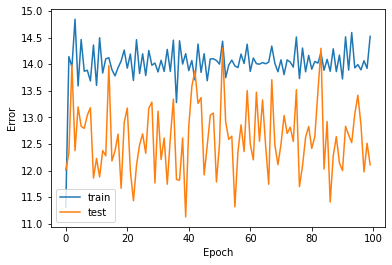

In [22]:
rbm100 = create_rbm(train_matrix, test_matrix, 100, 10000, 100)

In [23]:
evaluate_rbm(rbm100)

Vanilla RBM
hr 0.2439232279569565
recall 0.03237493304805827
ndcg 0.030961668753552204


start training


100%|██████████| 10/10 [03:32<00:00, 21.29s/it]


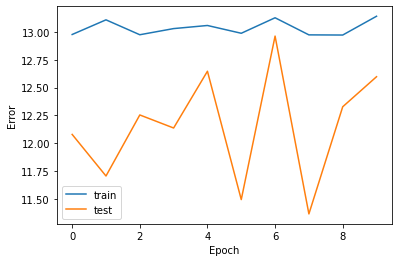

In [30]:
rbm20 = create_rbm(train_matrix, test_matrix, 1024, 8000, 10, rbm10)

In [31]:
evaluate_rbm(rbm20)

Vanilla RBM
hr 0.165605394495987
recall 0.020594391883720232
ndcg 0.021948495169053523


In [44]:
recommend(rbm10, train_matrix[100], test_matrix[100], 10)

average value tensor(0.0512, device='cuda:0')
values tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
recommended [1496, 1494, 1341, 1482, 204, 110, 328, 1289, 1992, 2001]
real [  58 1698]
len real 2


[1496, 1494, 1341, 1482, 204, 110, 328, 1289, 1992, 2001]

start training


100%|██████████| 100/100 [12:01<00:00,  7.21s/it]


Vanilla RBM
hr 0.24652592806806595
recall 0.031584133072314384
ndcg 0.03299444198698542


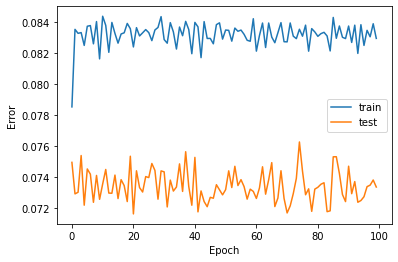

In [ ]:
rbm100 = create_rbm(train_matrix, test_matrix, 1024, 10240, 100)
evaluate_rbm(rbm100)

start training


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


start training


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


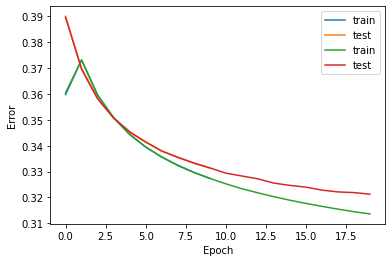

In [ ]:
rbm20 = create_rbm(train_matrix, test_matrix, 1024, 8000, 20)

In [ ]:
print("10 epochs")
hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm10)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

print("20 epochs")
hr, r, ndcg = compute_hr(train_matrix, test_matrix,rbm20)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

print("popularity")
hr,r ,ndcg = compute_hr2(popularity.index)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

print("popularity incorporated")
hr, r, ndcg = compute_hr3(rbm10, value_list)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))


10 epochs


C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/1456703759.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.16397621070518267
recall 0.14067645749888738
ndcg 0.061827593236468144
20 epochs
hr 0.08532588906420682
recall 0.07026338147833475
ndcg 0.03024630619216261


In [32]:
def recommend(rbm, v, vt, k, p=True):
    target_data = vt.data
    target_index = vt.indices
    target_recommendations = target_index[target_data == 1]
    v = v.todense()
    # v = v - 1
    v = torch.Tensor(v)
    if torch.cuda.is_available():
        v = v.cuda()
    
    _, h = rbm.sample_h(v)
    recommended, _ = rbm.sample_v(h)

    # all recommendations
    values, indices =  torch.topk(recommended[v < 1], k)
    recommendations = indices.cpu().tolist()

    if p:
        # print('20', recommended[0][20])
        # print('21', recommended[0][21])
        print("average value", torch.mean(recommended[0]))

    found = True
    for r in recommendations:
        if r in target_recommendations:
            if p:
                print("HIT")
            found = True
            break

    if found and p:
        print("values", values)
        print("recommended", recommendations)
        print("real", target_recommendations)
        print("len real", len(target_recommendations))

    
    
    return recommendations

user = 100
# print("train", train_matrix[user])
# print("test", test_matrix[user])


In [ ]:

print("EPOCHS 10")
recommend(rbm10, train_matrix[user], test_matrix[user], 10)
print('---' * 10)
print("EPOCHS 100")
recommend(rbm100, train_matrix[user], test_matrix[user], 10)

In [27]:
import gc

gc.collect()

torch.cuda.empty_cache()

start training


100%|██████████| 2000/2000 [2:13:47<00:00,  4.01s/it]


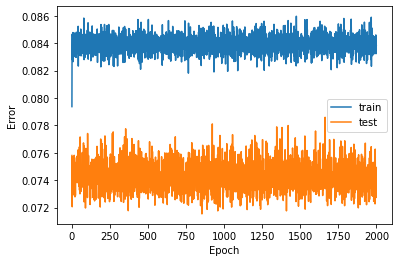

In [ ]:
rbm2000 = create_rbm(train_matrix, test_matrix, 100, 10000, 2000)

In [ ]:

recommend(rbm2000, train_matrix[user], test_matrix[user], 10)

average value tensor(0.0020, device='cuda:0')
values tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9857, 0.7724, 0.7508, 0.7067, 0.6375,
        0.6081], device='cuda:0')
recommended [63, 1350, 204, 186, 271, 1277, 1906, 43, 1884, 19]
real [  58  101  157  171  178  221  229  318  532  576 1698]
len real 11


[63, 1350, 204, 186, 271, 1277, 1906, 43, 1884, 19]

In [ ]:
print("2000 epochs")
hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm2000)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

2000 epochs
hr 0.26885435533705726
recall 0.036593026174615496
ndcg 0.03986529999302447


In [ ]:
# hrs = []
# rs = []
# for i in range(10):
#     rbm = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, i)
#     hr, r = compute_hr(rbm)
#     hrs.append(np.average(hr))
#     rs.append(np.average(r))

In [ ]:
# plt.clf()
# plt.plot(hrs, label='HR')
# plt.plot(rs, label='Recall')
# plt.xlabel("Epochs")
# plt.legend()

In [ ]:
rbm1 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 50)
hr, r, ndcg = compute_hr(rbm1)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(r))

start training


100%|██████████| 50/50 [00:46<00:00,  1.06it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_22208/2552676182.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


ValueError: too many values to unpack (expected 2)

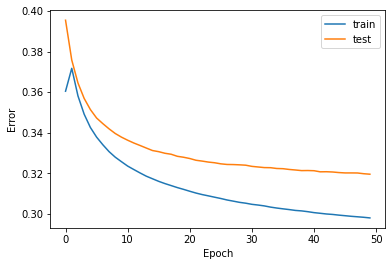

In [ ]:
rbm50 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 50)
hr, r = compute_hr(rbm50)
print("hr", np.average(hr))
print("recall", np.average(r))

In [ ]:
print("EPOCHS 50")
recommend(rbm50, train_matrix[user], test_matrix[user], 10)

EPOCHS 50
20 tensor(0.9153, device='cuda:0')
21 tensor(0.9358, device='cuda:0')
tensor(0.6323, device='cuda:0')
values tensor([0.9930, 0.9917, 0.9917, 0.9910, 0.9908, 0.9906, 0.9888, 0.9876, 0.9863,
        0.9855], device='cuda:0')
recommended [0, 139, 36, 331, 93, 62, 54, 110, 34, 195]
real [20 21]


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/3369171806.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


True

start training


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/1456703759.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.0282801310838694
recall 0.021958571023991583
ndcg 0.012341552449629993


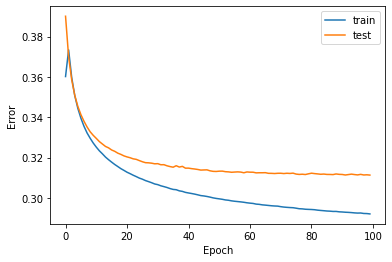

In [ ]:
rbm100 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 100)
hr, r, ndcg = compute_hr(rbm100)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

In [ ]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm50, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


95


In [ ]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm20, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


88


In [ ]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm10, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


77


In [ ]:
print(train_matrix.shape[1])

3682


start training


100%|██████████| 500/500 [07:14<00:00,  1.15it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.043295398317664525
recall 0.034960003298697015


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


113


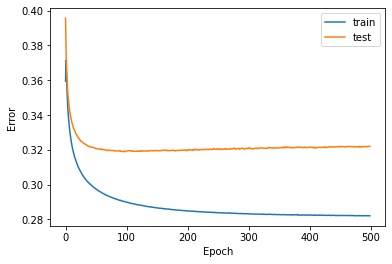

In [ ]:
rbm500 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 500)
hr, r = compute_hr(rbm50)
print("hr", np.average(hr))
print("recall", np.average(r))

all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm500, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

In [ ]:
hr, r = compute_hr(rbm500)
print("hr", np.average(hr))
print("recall", np.average(r))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.02016328550222662
recall 0.015879102754412004


start training


100%|██████████| 2000/2000 [28:52<00:00,  1.15it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/1456703759.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.02730913945867217
recall 0.02056277056277056
ndcg 0.009893964932566628


NameError: name 'recommend' is not defined

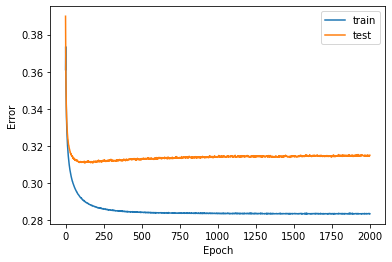

In [ ]:
rbm2000 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 2000)
hr, r, ndcg = compute_hr(rbm2000)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm2000, train_matrix[u], test_matrix[u], 10, u == train_matrix.shape[0] - 1)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

## Hyperparam searching

start training


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 100/100 [03:46<00:00,  2.26s/it]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 100/100 [06:29<00:00,  3.89s/it]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


{'100-[100, 1000, 5000, 10000]': ([1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

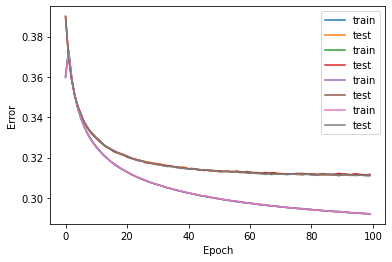

In [ ]:
epochs = [100]
hidden = [100, 1000, 5000, 10000]
rbms = []
results = {}

for epoch in epochs:
    for n_hidden in hidden:
        rbm = create_rbm(train_matrix, test_matrix, n_hidden, 10240, epoch)
        rbms.append(rbm)
        hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm)
        results[f"{epoch}-{n_hidden}"] = (np.average(hr), np.average(r), np.average(ndcg))

results

In [ ]:
for i, rbm in enumerate(rbms):
    hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm)
    results[f"{100}-{hidden[i]}"] = (np.average(hr), np.average(r), np.average(ndcg))
    
results

C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


{'100-[100, 1000, 5000, 10000]': (0.038232795242141036,
  0.029048832787150546,
  0.015129883968285325),
 '100-100': (0.03859691710159, 0.029321924181737263, 0.01330594743959745),
 '100-1000': (0.03422745478820245, 0.026054941942792405, 0.012561496199119393),
 '100-5000': (0.03799004733584173, 0.02899826030667152, 0.013694640578542241),
 '100-10000': (0.038232795242141036,
  0.029048832787150546,
  0.015129883968285325)}

In [ ]:
import pprint
pprint.pprint(results)

{'100-100': (0.03859691710159, 0.029321924181737263, 0.01330594743959745),
 '100-1000': (0.03422745478820245, 0.026054941942792405, 0.012561496199119393),
 '100-10000': (0.038232795242141036,
               0.029048832787150546,
               0.015129883968285325),
 '100-5000': (0.03799004733584173, 0.02899826030667152, 0.013694640578542241),
 '100-[100, 1000, 5000, 10000]': (0.038232795242141036,
                                  0.029048832787150546,
                                  0.015129883968285325)}


In [ ]:
torch.save(rbm.state_dict(), "./network")

In [ ]:
# rbm = RBM(n_vis, n_hidden)
# rbm.load_state_dict(torch.load("./network"))
# rbm.eval()